# **Dependincies**

In [1]:
%%capture
!pip install lightgbm==3.3.2
!pip install catboost==1.2.2
!pip install xgboost==2.0.3
!pip install optuna
!pip install timm
!pip install pyspellchecker
!pip install lifelines

In [2]:
import pandas as pd
import numpy as np
from time import time
import re
import gc
import shutil
import os
import math
import random
import importlib
import warnings
import pickle
import joblib
from tqdm import tqdm
import sys
from pathlib import Path
import string

from scipy.stats import skew, kurtosis
from collections import Counter,defaultdict
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost as cat, gc
import xgboost

print(lgb.__version__)
print(cat.__version__)
print(xgboost.__version__)

from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBClassifier

import optuna

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.nn.functional as F

from transformers import AutoModel,AutoTokenizer
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

compe_name = 'RNA'
sys.path.append(f'/notebooks/{compe_name}/utils')

3.3.2
1.2.2
2.0.3


2025-03-31 12:34:33.727141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 12:34:33.727227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 12:34:33.834183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 12:34:34.050544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 12:34:35.589169: W tensorflow/compiler/tf2

In [3]:
import utils as my_utils
from utils import clr
from metric import score

In [4]:
# FE = my_utils.CIBMTR_FE(mode='train')

# **CONFIG**

In [5]:
train_seq_path = f'/notebooks/{compe_name}/data/train_sequences.csv'
train_labels_path = f'/notebooks/{compe_name}/data/train_labels.csv'

val_seq_path = f'/notebooks/{compe_name}/data/validation_sequences.csv'
val_labels_path = f'/notebooks/{compe_name}/data/validation_labels.csv'

test_seq_path = f'/notebooks/{compe_name}/data/test_sequences.csv'
sub_path = f'/notebooks/{compe_name}/data/sample_submission.csv'

In [6]:
train_seq = pd.read_csv(train_seq_path)
train_labels = pd.read_csv(train_labels_path)
train_labels["pdb_id"] = train_labels["ID"].apply(lambda x: x.split("_")[0]+'_'+x.split("_")[1])

val_seq = pd.read_csv(val_seq_path)
val_labels = pd.read_csv(val_labels_path)
val_labels["pdb_id"] = val_labels["ID"].apply(lambda x: x.split("_")[0])

test_seq = pd.read_csv(test_seq_path)
submission = pd.read_csv(sub_path)

In [7]:
print(f'train_sequence shape: {train_seq.shape}')
print(f'val_sequence shape: {val_seq.shape}')
print(f'test_sequence shape: {test_seq.shape}')
print('')
print(f'train_labels shape: {train_labels.shape}')
print(f'val_labels shape: {val_labels.shape}')

train_sequence shape: (844, 5)
val_sequence shape: (12, 5)
test_sequence shape: (12, 5)

train_labels shape: (137095, 7)
val_labels shape: (2515, 124)


In [8]:
all_xyz=[]

for pdb_id in tqdm(train_seq['target_id']):
    df = train_labels[train_labels["pdb_id"]==pdb_id]
    #break
    xyz=df[['x_1','y_1','z_1']].to_numpy().astype('float32')
    xyz[xyz<-1e17]=float('Nan');
    all_xyz.append(xyz)

100%|██████████| 844/844 [00:05<00:00, 156.66it/s]


In [9]:
# all_xyz

# **SEQUENCE DATA**
* Validataion_sequences:2022年の CASP15 コンペティション からの12のターゲットが含まれており、RNAモデリング分野で広く使用されているテストセットです,
* test_sequencesとValidataion_sequencesは全く同じ


In [10]:
train_seq.head(3)

,target_id,sequence,temporal_cutoff,description,all_sequences
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1995-01-26,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU,1995-02-27,THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...,>1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU,1995-06-03,24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...,>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...


In [11]:
val_seq.head(3)

,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."


In [12]:
'''
【リークに関しての警告】
提供された12の CASP15 ターゲットをバリデーションに使用する場合、test_sequencesの
temporal_cutoff（2022-05-27）以前に公開された train_sequences.csv のみを学習に使用してください
2022-05-27以降の train_sequences.csv は、追加のバリデーションセットとして使用することが可能です。
'''
test_seq.head(3)

,target_id,sequence,temporal_cutoff,description,all_sequences
0,R1107,GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUU...,2022-05-28,CPEB3 ribozyme\nHuman\nhuman CPEB3 HDV-like ri...,>7QR4_1|Chain A|U1 small nuclear ribonucleopro...
1,R1108,GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUU...,2022-05-27,CPEB3 ribozyme\nChimpanzee\nChimpanzee CPEB3 H...,">7QR3_1|Chains A, B|U1 small nuclear ribonucle..."
2,R1116,CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGG...,2022-06-04,Cloverleaf RNA\nPoliovirus\nCrystal Structure ...,">8S95_1|Chain A[auth C]|Lysine tRNA scaffold,P..."


In [13]:
print(f'train_sequence shape: {train_seq.shape}')
print(f'val_sequence shape: {val_seq.shape}')
print(f'val_sequence shape: {test_seq.shape}')

train_sequence shape: (844, 5)
val_sequence shape: (12, 5)
val_sequence shape: (12, 5)


## **Sequence**

In [14]:
train_seq["sequence_length"] = train_seq["sequence"].apply(lambda x: len(x))

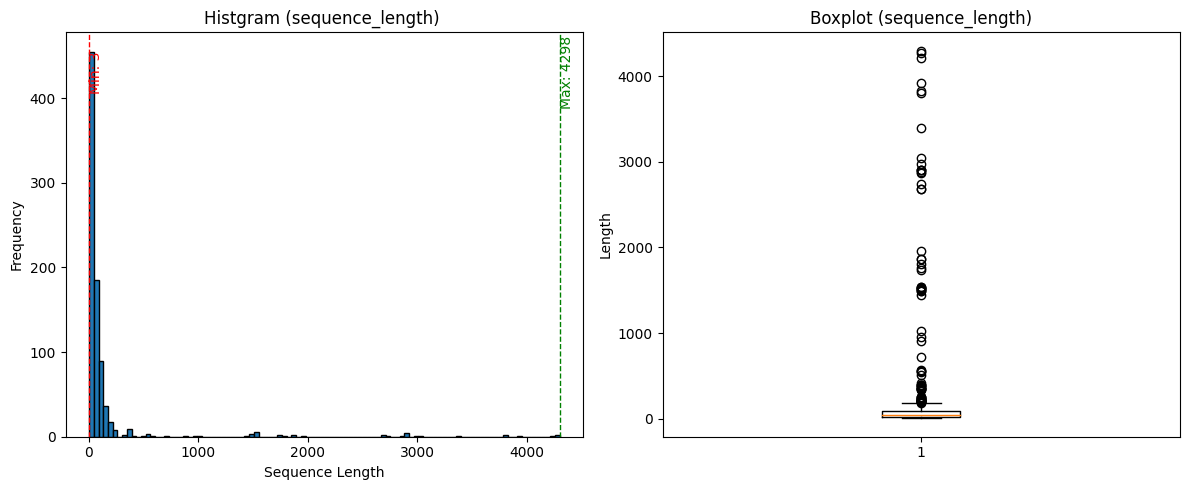

In [15]:
tmp = train_seq["sequence_length"]
# 最小値と最大値を計算
min_val = tmp.min()
max_val = tmp.max()

# 1行2列のグラフ領域を作成
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左側：ヒストグラム
axes[0].hist(tmp, bins=100, edgecolor='black')
axes[0].axvline(min_val, color='red', linestyle='dashed', linewidth=1)
axes[0].axvline(max_val, color='green', linestyle='dashed', linewidth=1)
ymax = axes[0].get_ylim()[1]
axes[0].text(min_val, ymax * 0.9, f'Min: {min_val}', color='red', rotation=90, va='center')
axes[0].text(max_val, ymax * 0.9, f'Max: {max_val}', color='green', rotation=90, va='center')
axes[0].set_title("Histgram (sequence_length) ")
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Frequency")

# 右側：ボックスプロット
axes[1].boxplot(tmp)
axes[1].set_title("Boxplot (sequence_length)")
axes[1].set_ylabel("Length")

plt.tight_layout()
plt.show()

In [16]:
"""
trainとvalでsequence(RNA配列)の最大を抜き出した。
trainは最大4298の長さのRNA１配列があり(target_id=4V6X_A5)、valは最大30の長さのRNA配列がある。
"""
max_length = train_seq["sequence_length"].max()
longest_sequences = train_seq[train_seq["sequence_length"] == max_length]

print(f'Max train_sequence: {longest_sequences["sequence"].item()}')
print(f'length of Max train_sequence shape: {len(longest_sequences["sequence"].item())}')
print(f'target_id of Max train_sequence shape: {longest_sequences["target_id"].item()}')
print('')

# print(f'Max val_sequence: {val_seq["sequence"].max()}')
# print(f'length of Max val_sequence: {len(val_seq["sequence"].max())}')

Max train_sequence: CGCGACCUCAGAUCAGACGUGGCGACCCGCUGAAUUUAAGCAUAUUAGUCAGCGGAGGAGAAGAAACUAACCAGGAUUCCCUCAGUAACGGCGAGUGAACAGGGAAGAGCCCAGCGCCGAAUCCCCGCCCCGCGGCGGGGCGCGGGACAUGUGGCGUACGGAAGACCCGCUCCCCGGCGCCGCUCGUGGGGGGCCCAAGUCCUUCUGAUCGAGGCCCAGCCCGUGGACGGUGUGAGGCCGGUAGCGGCCCCCGGCGCGCCGGGCCCGGGUCUUCCCGGAGUCGGGUUGCUUGGGAAUGCAGCCCAAAGCGGGUGGUAAACUCCAUCUAAGGCUAAAUACCGGCACGAGACCGAUAGUCAACAAGUACCGUAAGGGAAAGUUGAAAAGAACUUUGAAGAGAGAGUUCAAGAGGGCGUGAAACCGUUAAGAGGUAAACGGGUGGGGUCCGCGCAGUCCGCCCGGAGGAUUCAACCCGGCGGCGGGUCCGGCCGUGUCGGCGGCCCGGCGGAUCUUUCCCGCCCCCCGUUCCUCCCGACCCCUCCACCCGCCCUCCCUUCCCCCGCCGCCCCGGGCUCCGGCGGGUGCGGGGGUGGGCGGGCGGGGCCGGGGGUGGGGUCGGCGGGGGACCGUCCCCCGACCGGCGACCGGCCGCCGCCGGGCGCAUUUCCACCGCGGCGGUGCGCCGCGACCGGCUCCGGGACGGCUGGGAAGGCCCGGCGGGGAAGGUGGCUCGGGGGGCCCCGUCCGUCCGUCCGGCGGCGGCGGCGGCGGCGGGACCGAAACCCCCCCCGAGUGUUACAGCCCCCCCGGCAGCAGCACUCGCCGAAUCCCGGGGCCGAGGGAGCGAGACCCGUCGCCGCGCUCUCCCCCCUCCCGGCGCCCACCCCCGCGGGGACUCCCCCGCGGGGGCGCGCCGGCGUCUCCUCGUGGGGGGGCCGGGCCACCCCUCCCACGGCGCGACCGCUCUCCCACCCCUCCUC

In [17]:
"""
train_seqには、重複するものが45種類、存在する。
また、最大5個重複しているRNA配列が存在するが、それぞれはtarget_id、temporal_cutoffなどが異なる。
"""
tmp=train_seq[train_seq.duplicated(subset=['sequence'], keep=False)]
print(f'train_seqの重複が確認されるRNA配列の種類数： {tmp["sequence"].nunique()}')

sequence_counts = train_seq['sequence'].value_counts()
max_count = sequence_counts.max()
most_duplicated_sequences = sequence_counts[sequence_counts == max_count].index.tolist()
most_duplicated_rows = train_seq[train_seq['sequence'].isin(most_duplicated_sequences)].reset_index(drop=True)
print(f"最大の重複数: {max_count}")
most_duplicated_rows.head(10)

train_seqの重複が確認されるRNA配列の種類数： 45
最大の重複数: 5


,target_id,sequence,temporal_cutoff,description,all_sequences,sequence_length
0,1ZDI_S,ACAUGAGGAUUACCCAUGU,1997-04-21,RNA BACTERIOPHAGE MS2 COAT PROTEIN/RNA COMPLEX,">1ZDI_1|Chains A[auth R], B[auth S]|RNA (5'-R(...",19
1,2BQ5_S,ACAUGAGGAUUACCCAUGU,2006-03-22,MS2 (N87AE89K mutant) - RNA hairpin complex,">2BQ5_1|Chains A, B, C|COAT PROTEIN|BACTERIOPH...",19
2,2BQ5_R,ACAUGAGGAUUACCCAUGU,2006-03-22,MS2 (N87AE89K mutant) - RNA hairpin complex,">2BQ5_1|Chains A, B, C|COAT PROTEIN|BACTERIOPH...",19
3,2B2E_R,ACAUGAGGAUUACCCAUGU,2006-05-09,RNA stemloop from bacteriophage MS2 complexed ...,">2B2E_1|Chains A[auth R], B[auth S]|5'-R(*AP*C...",19
4,2B2E_S,ACAUGAGGAUUACCCAUGU,2006-05-09,RNA stemloop from bacteriophage MS2 complexed ...,">2B2E_1|Chains A[auth R], B[auth S]|5'-R(*AP*C...",19
5,8SFO_B,UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA,2024-07-03,WT CRISPR-Cas12a with a 20bp R-loop and nontar...,>8SFO_1|Chain A|CRISPR-associated endonuclease...,48
6,8SFI_B,UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA,2024-07-03,WT CRISPR-Cas12a with a 8bp R-loop,>8SFI_1|Chain A|CRISPR-associated endonuclease...,48
7,8SFL_B,UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA,2024-07-03,WT CRISPR-Cas12a with a 15bp R-loop,>8SFL_1|Chain A|CRISPR-associated endonuclease...,48
8,8SFN_B,UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA,2024-07-03,WT CRISPR-Cas12a with a 16bp R-loop and nontar...,>8SFN_1|Chain A|CRISPR-associated endonuclease...,48
9,8SFJ_B,UUUUUAAUUUCUACUCUUGUAGAUGUGAUAAGUGGAAUGCCAUGUGGA,2024-07-03,WT CRISPR-Cas12a with a 10bp R-loop,>8SFJ_1|Chain A|CRISPR-associated endonuclease...,48


In [18]:
'''
5つ重複があるsequenceである、'ACAUGAGGAUUACCCAUGU'を例にする。
>target_id 全て異なる。
>temporal_cutoff 重複する場合もある。
>description 重複する場合もある。
>all_sequences 重複する場合もある。
>'2BQ5_S'と'2BQ5_R'については、target_id以外は全て同じ。
>'2B2E_R'と'2B2E_S'についても、target_id以外は全て同じ。
'''

duplicated_seq = 'ACAUGAGGAUUACCCAUGU'
tmp=most_duplicated_rows[most_duplicated_rows['sequence']==duplicated_seq]
for i in range(len(tmp)):
    # display(tmp.head())
    print(f'target_id : {tmp.loc[i, "target_id"]}')
    print(f'temporal_cutoff : {tmp.loc[i, "temporal_cutoff"]}')
    print(f'description : {tmp.loc[i, "description"]}')
    print(clr.RED + f'all_sequences' + clr.END)
    print(clr.RED + f'{tmp.loc[i, "all_sequences"]}' + clr.END)
    print('')

# '2BQ5_S'と'2BQ5_R'の'all_sequences'の照合結果
match1=train_seq[train_seq['target_id']=='2BQ5_S']['all_sequences'].item() == train_seq[train_seq['target_id']=='2BQ5_R']['all_sequences'].item()
print(match1)

# '2B2E_R'と'2B2E_S'の'all_sequences'の照合結果
match2=train_seq[train_seq['target_id']=='2B2E_R']['all_sequences'].item() == train_seq[train_seq['target_id']=='2B2E_S']['all_sequences'].item()
print(match2)

target_id : 1ZDI_S
temporal_cutoff : 1997-04-21
description : RNA BACTERIOPHAGE MS2 COAT PROTEIN/RNA COMPLEX
all_sequences
>1ZDI_1|Chains A[auth R], B[auth S]|RNA (5'-R(*AP*CP*AP*UP*GP*AP*GP*GP*AP*UP*UP*AP*CP*CP*CP*AP*U P*GP*U)-3')|
ACAUGAGGAUUACCCAUGU
>1ZDI_2|Chains C[auth A], D[auth B], E[auth C]|PROTEIN (RNA BACTERIOPHAGE MS2 COAT PROTEIN)|Enterobacterio phage MS2 (12022)
ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTCSVRQSSAQNRKYTIKVEVPKVATQTVGGVELPVAAWRSYLNMELTIPIFATNSDCELIVKAMQGLLKDGNPIPSAIAANSGIY


target_id : 2BQ5_S
temporal_cutoff : 2006-03-22
description : MS2 (N87AE89K mutant) - RNA hairpin complex
all_sequences
>2BQ5_1|Chains A, B, C|COAT PROTEIN|BACTERIOPHAGE MS2 (12022)
ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTCSVRQSSAQNRKYTIKVEVPKVATQTVGGVELPVAAWRSYLAMKLTIPIFATNSDCELIVKAMQGLLKDGNPIPSAIAANSGIY
>2BQ5_2|Chains D[auth R], E[auth S]|5'-R(*AP*CP*AP*UP*GP*AP*GP*GP*AP*UP *UP*AP*CP*CP*CP*AP*UP*GP*U)-3'|BACTERIOPHAGE MS2 (12022)
ACAUGAGGAUUACCCAUGU


target_id : 2BQ5_R
temporal

## **all sequence**
* all_sequences（文字列）：その実験的に解明された構造に含まれる全分子のFASTA形式配列。
* 場合によっては、ターゲットRNAの複数コピーや、RNA・タンパク質・DNAなどの相互作用分子を含むことがあります（Chainsという単語がヘッダーに含まれる）。
* 予測が必要なのはsequenceのみです。もし他の分子を予測した場合でも、sequenceに対応する予測のみ提出してください。
* 一部のエントリーでは、このカラムが空白のこともあります。

In [19]:
for i in range(5):
    print(clr.GREEN + train_seq['target_id'][i] + clr.END)
    print(clr.RED + train_seq['sequence'][i] + clr.END)
    print(train_seq['all_sequences'][i])

1SCL_A
GGGUGCUCAGUACGAGAGGAACCGCACCC
>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus norvegicus (10116)
GGGUGCUCAGUACGAGAGGAACCGCACCC

1RNK_A
GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
>1RNK_1|Chain A|RNA PSEUDOKNOT|null
GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU

1RHT_A
GGGACUGACGAUCACGCAGUCUAU
>1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*GP*AP*CP*GP*AP*UP*CP*AP*CP*GP*CP*AP*GP*UP*CP*UP*AP*U)-3')|null
GGGACUGACGAUCACGCAGUCUAU

1HLX_A
GGGAUAACUUCGGUUGUCCC
>1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*AP*UP*AP*AP*CP*UP*UP*CP*GP*GP*UP*UP*GP*UP*CP*CP*C)-3')|null
GGGAUAACUUCGGUUGUCCC

1HMH_E
GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU
>1HMH_1|Chains A, C, E|HAMMERHEAD RIBOZYME-RNA STRAND|
GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU
>1HMH_2|Chains B, D, F|HAMMERHEAD RIBOZYME-DNA STRAND|
ACGGTCGGTCGCC



# **LABEL DATA**

In [20]:
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1,pdb_id
0,1SCL_A_1,G,1,13.760,-25.974001,0.102,1SCL_A
1,1SCL_A_2,G,2,9.310,-29.638000,2.669,1SCL_A
2,1SCL_A_3,G,3,5.529,-27.813000,5.878,1SCL_A
3,1SCL_A_4,U,4,2.678,-24.900999,9.793,1SCL_A
4,1SCL_A_5,G,5,1.827,-20.136000,11.793,1SCL_A


In [21]:
val_labels.head()

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40,pdb_id
0,R1107_1,G,1,-5.499,8.520000,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107
1,R1107_2,G,2,-5.826,10.453000,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107
2,R1107_3,G,3,-5.849,14.768000,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107
3,R1107_4,G,4,-5.784,19.985001,18.666000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107
4,R1107_5,G,5,-5.755,25.533001,17.132999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,R1107


In [22]:
print(val_labels['pdb_id'].nunique())

12
